# Figures 7, S20, S21: Influence of downscaling parameters on volume and runoff

- creates these plots for the manuscript and supplements:
    - `fig_7_conceptual_parameter_vol_runoff_influence_2003_2099_sfc_type_no_mb_monthly_RGI60-11.01450_median_gcm.pdf`
    - `fig_S20_conceptual_parameter_runoff_components_influence_2003_2099_sfc_type_no_mb_monthly_RGI60-11.01450_median_gcm.pdf`
    - `fig_S21_conceptual_parameter_runoff_influence_2003_2099_sfc_type_no_mb_monthly_RGI60-11.01450_median_gcm.pdf`

In [6]:
# make sure to have the correct OGGM version...
# pip install --upgrade "git+https://github.com/OGGM/oggm.git@9d173038862f36a21838034da07243bd189ef2d0"

In [1]:
# path where OGGM gdirs are: is created in data_creating_scripts
working_dir = '../oggm_run_gdir_folder/node_folder'
# figure path
fig_path = '../figures'
# data path -> data created from 00_data_creating scripts
data_path = '../01_data'

In [2]:
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import xarray as xr

plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
import numpy as np
import pandas as pd

# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
from oggm.tasks import run_with_hydro

import MBsandbox
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, TIModel, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data, process_isimip_data_no_corr
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf, minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel
from MBsandbox.flowline_TIModel import run_from_climate_data_TIModel

import time
import logging

log = logging.getLogger(__name__)

base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')
climate_type = 'W5E5'

# get the geodetic calibration data
pd_geodetic_all = utils.get_geodetic_mb_dataframe()
# pd_geodetic_all = pd.read_hdf(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']

_, pathi = utils.get_wgms_files()
pd_mb_overview = pd.read_csv(pathi[:-len('/mbdata')] + '/mb_overview_seasonal_mb_time_periods_20220301.csv',
                             index_col='Unnamed: 0')
pd_wgms_data_stats = pd.read_csv(pathi[:-len('/mbdata')] + '/wgms_data_stats_20220301.csv', index_col='Unnamed: 0')
# should have at least 5 annual MB estimates in the time period 1980-2019
# (otherwise can also not have MB profiles or winter MB!)
pd_wgms_data_stats = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=5]
ref_candidates = pd_wgms_data_stats.rgi_id.unique()

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = False #True
cfg.PATHS['working_dir'] = working_dir
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1
#cfg.PARAMS['continue_on_error'] = True
# Hydro outputs needs the full model geometry
cfg.PARAMS['store_model_geometry'] = True 
cfg.PARAMS['continue_on_error'] = False

warnings.filterwarnings("ignore", category=DeprecationWarning) 

correction = False
gcms = [ 'mri-esm2-0', 'ukesm1-0-ll','gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr']

2023-06-14 14:45:17: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-06-14 14:45:17: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-06-14 14:45:17: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-06-14 14:45:17: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


## Fig. 7 and Fig. S11:

In [ ]:
#df = ['RGI60-11.00897']
df = ['RGI60-11.01450']
gdirs = workflow.init_glacier_directories(df)
gdir = gdirs[0]
melt_f = 200
pf = 1.5

try:
    y0 = gdirs[0].get_climate_info('_daily_W5E5')['baseline_hydro_yr_0']
    # One adds 1 because the run ends at the end of the year
    ye = gdirs[0].get_climate_info('_daily_W5E5')['baseline_hydro_yr_1'] + 1
except:
    y0 = gdirs[0].get_climate_info('_daily_W5E5')['baseline_yr_0']
    # One adds 1 because the run ends at the end of the year
    ye = gdirs[0].get_climate_info('_daily_W5E5')['baseline_yr_1'] + 1 
    print(y0,ye)

# get the geodetic data for calibration
pd_geodetic = oggm.utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
mb_geodetic = pd_geodetic.loc[df].dmdtda.values * 1000
years = np.arange(2000, 2020, 1)
fls = gdir.read_pickle('inversion_flowlines')
h,w = gdir.get_inversion_flowline_hw()

mb_type = 'mb_monthly' 

sfc_type_distinction = 'no'


grad_type = 'cte'
baseline_climate='W5E5'
if sfc_type_distinction == 'monthly_neg_exp':
    mb_model_sub_class = TIModel_Sfc_Type
    melt_f_update = 'monthly'
    kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp', 'tau_e_fold_yr':1,
                                   'spinup_yrs':6, 'melt_f_update':melt_f_update,
                                    'melt_f_ratio_snow_to_ice':0.5}
elif sfc_type_distinction == 'annual_neg_exp':
    mb_model_sub_class = TIModel_Sfc_Type
    melt_f_update = 'annual'
    kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp', 'tau_e_fold_yr':1,
                                   'spinup_yrs':6, 'melt_f_update':melt_f_update,
                                    'melt_f_ratio_snow_to_ice':0.5}
elif sfc_type_distinction == 'no':
    mb_model_sub_class = TIModel
    kwargs_for_TIModel_Sfc_Type = {}
    
    
mb = mb_model_sub_class(gdir, 200, mb_type=mb_type, grad_type = grad_type,
                         prcp_fac=2.5,
                         baseline_climate=baseline_climate, **kwargs_for_TIModel_Sfc_Type)

gdirs = [gdirs[0]]

runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'volume_m3']

mbdf = gdir.get_ref_mb_data(input_filesuffix='_monthly_W5E5')
ys_glac = mbdf.index.values

pf_to_model = np.arange(0.2, 5.1, 0.5) # #[0.2,0.25, 0.33,0.5,1,2,3,4,5] #np.arange(0.2, 5.1, 0.5) # 0.1 ... #[0.1, 0.3, 0.7, 1, 1.5, 2, 2.5, 3, 4, 5]
# pf_to_model = [0.2, 1,1.25, 1.5, 2, 4, ]
temp_bias_to_model = np.arange(-5,5.01,1) # changed from 0.1 ..to 0.4, as we only plotted every 4th run anyways ...
pf_to_model_zippi = np.concatenate([pf_to_model, np.repeat(2,len(temp_bias_to_model))])
temp_bias_to_model_zippi = np.concatenate([np.repeat(0, len(pf_to_model)), temp_bias_to_model])
temp_b_l = []
melt_f_l = []
pf_l = []
mb_annual_l = []
volume_l = []
runoff_l = []
gcm_l = []
runoff_vars_d = {'melt_off_glacier':[], 'melt_on_glacier': [], 'liq_prcp_off_glacier':[],
                 'liq_prcp_on_glacier':[], 'volume_m3':[]}
load = True ### actually I always need to load it as it makes strings out of the [] arrays ... 
if load:
    for pf,temp_b in zip(pf_to_model_zippi,temp_bias_to_model_zippi):
        try:
            mb.temp_bias = temp_b
            melt_f = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                                          xtol=0.01,
                                                          args=(mb, mb_geodetic, h, w, pf),
                                                          disp=True)

            mb.melt_f = melt_f
            mb.prcp_fac = pf #pf_cte = pf_cte
            # first get it in "ascending" order (necessary for sfc type distinction) !
            mb.get_specific_mb(heights=h, widths=w,
                                                year=np.arange(1979,2020,1))

            # direct annual time series:
            mb_annual = mb.get_specific_mb(heights=h, widths=w,
                                            year=ys_glac)

            oggm.core.climate.apparent_mb_from_any_mb(gdir, mb_model=mb,
                                                  mb_years=np.arange(2000, ye, 1))
            # here glen-a is calibrated to match gdirs glaciers in total 
            # (as there is only one glacier, it just matches perfectly the one glacier!)
            border = 80
            filter = border >= 20
            pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus([gdir],
                                                                  apply_fs_on_mismatch=False,ignore_missing=False,
                                                                  error_on_mismatch=True,
                                                                  filter_inversion_output=filter)

            # so for init_present_time_glacier, automatically the new glen a volume inversion is used!
            workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs) #gdirs_sel)
            output_filesuffix = f'pf_var_hydro_historical_W5E5_pf{pf:.2}_tb{temp_b:.2}_{mb_type}_{grad_type}_no_melt_f_change'
            workflow.execute_entity_task(run_with_hydro,
                                         gdirs, run_task=run_from_climate_data_TIModel,
                                             bias=0,  # will actually point to the residual, should always be zero! 
                                             mb_model_sub_class=mb_model_sub_class,  # we use the temperature-index model variant with surface type distinction!
                                             min_ys=y0,
                                             ye=ye,  # starting and end year of the volume run 
                                             mb_type=mb_type,
                                             grad_type=grad_type,
                                             precipitation_factor=pf,  # take the fitted precipitation factor
                                             temperature_bias = temp_b,
                                             melt_f=melt_f, # set to the calibrated melt_f (that fits to fit_prcp_fac_aneto)
                                             #init_model_filesuffix = '_historical_run',  # start from the stage of the end of the historical run 
                                             #climate_type = 'gcm_data',
                                             kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type,                             
                                             climate_filename='climate_historical',
                                             output_filesuffix=output_filesuffix,
                                             climate_input_filesuffix='W5E5', 
                                             store_model_geometry = True,
                                             all_from_json=False,
                                         no_qc=True)


            #for ensemble in gcms[3:]:
            ds_hydro_gcm_l = []
            for ensemble_s in gcms: #[gcms[0]]: #gcms:
                if ensemble_s == 'ukesm1-0-ll':
                    ensemble = ensemble_s + '_r1i1p1f2'
                else:
                    ensemble = ensemble_s + '_r1i1p1f1'
                for ssp in ['ssp126']: # 'ssp585', 
                    output_filesuffix_gcm = f'pf_var_hydro_{ensemble}_{ssp}_pf{pf:.2}_tb{temp_b:.2}_{mb_type}_{grad_type}_no_melt_f_change'
                    workflow.execute_entity_task(run_with_hydro,
                     gdirs, run_task=run_from_climate_data_TIModel,  # gdirs_sel
                                                 init_model_filesuffix=output_filesuffix,
                                                 ref_geometry_filesuffix=output_filesuffix,  # also use this as area reference!!!!
                                                 ref_area_from_y0=True, # keep the same reference area as historical time period!!!
                                                 bias=0,  # will actually point to the residual, should always be zero! 
                                                 mb_model_sub_class=mb_model_sub_class,  # we use the temperature-index model variant with surface type distinction!
                                                 ys=2019,
                                                 ye=2100,  # starting and end year of the volume run 
                                                 mb_type=mb_type,
                                                 grad_type=grad_type,
                                                 precipitation_factor=pf,  # take the fitted precipitation factor
                                                 temperature_bias = temp_b,
                                                 melt_f=melt_f, # set to the calibrated melt_f (that fits to fit_prcp_fac_aneto)
                                                 #init_model_filesuffix = '_historical_run',  # start from the stage of the end of the historical run 
                                                 #climate_type = 'gcm_data',
                                                 kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type,                             
                                                 climate_filename='gcm_data',
                                                 climate_input_filesuffix=f'ISIMIP3b_{ensemble}_{ssp}_no_correction', 
                                                 output_filesuffix=output_filesuffix_gcm,
                                                 store_model_geometry = True,
                                                 all_from_json=False,
                                                 no_qc=True)        

                    ds_hydro_p = xr.open_dataset(gdirs[0].get_filepath('model_diagnostics')[:-3] + output_filesuffix +'.nc')
                    ds_hydro_f = xr.open_dataset(gdirs[0].get_filepath('model_diagnostics')[:-3] + output_filesuffix_gcm +'.nc')
                    ds_hydro_gcm = xr.concat([ds_hydro_p.sel(time=slice(2003,2019)),
                                          ds_hydro_f], dim='time').sel(time=slice(2003,2099))
                    ds_hydro_gcm['gcm'] = ensemble
                    ds_hydro_gcm_l.append(ds_hydro_gcm)
            ds_hydro = xr.concat(ds_hydro_gcm_l, dim='gcm').median(dim='gcm')
            runoff_s = (ds_hydro[runoff_vars[0]] + ds_hydro[runoff_vars[1]] + ds_hydro[runoff_vars[2]]
                        + ds_hydro[runoff_vars[3]]).values/1e9  #in Mt
            # let's look at the average ... 
            mb_annual_l.append(mb_annual)
            gcm_l.append('median gcm') ### is this actually problematic to do that ??? -> extremes are getting "averaged" out ...
            runoff_l.append(runoff_s.mean())
            melt_f_l.append(melt_f)
            pf_l.append(pf.round(2))
            temp_b_l.append(temp_b)
            for runoff_v in runoff_vars:
                # let's look at the different components -> here we want to have the time series 
                runoff_vars_d[runoff_v].append(ds_hydro[runoff_v].values/1e9)
        except:
            print(temp_b, pf)
            pass

    # todo add the 4 different runoff components (as time series ...)
    pd_pf_data = pd.DataFrame(np.array([temp_b_l, pf_l, melt_f_l, runoff_l, mb_annual_l, gcm_l]).T,
                 columns = ['temp_b', 'pf', 'melt_f', 'avg. runoff', 'MB annual', 'gcm'])
    for runoff_v in runoff_vars:
        pd_pf_data[runoff_v] = runoff_vars_d[runoff_v]
    for j in pd_pf_data.index:
        #assert pd_pf_data[runoff_vars[:4]].sum(axis=1).iloc[j].mean() == pd_pf_data['avg. runoff'].iloc[j]
        np.testing.assert_allclose(pd_pf_data[runoff_vars[:4]].sum(axis=1).iloc[j].mean(), pd_pf_data['avg. runoff'].iloc[j])
    #pd_pf_data.to_csv(f'{data_path}_pf_temp_b_var_influence_runoff_W5E5_{ensemble}_{ssp}_{gdir.rgi_id}.csv')


#### Figure 7:

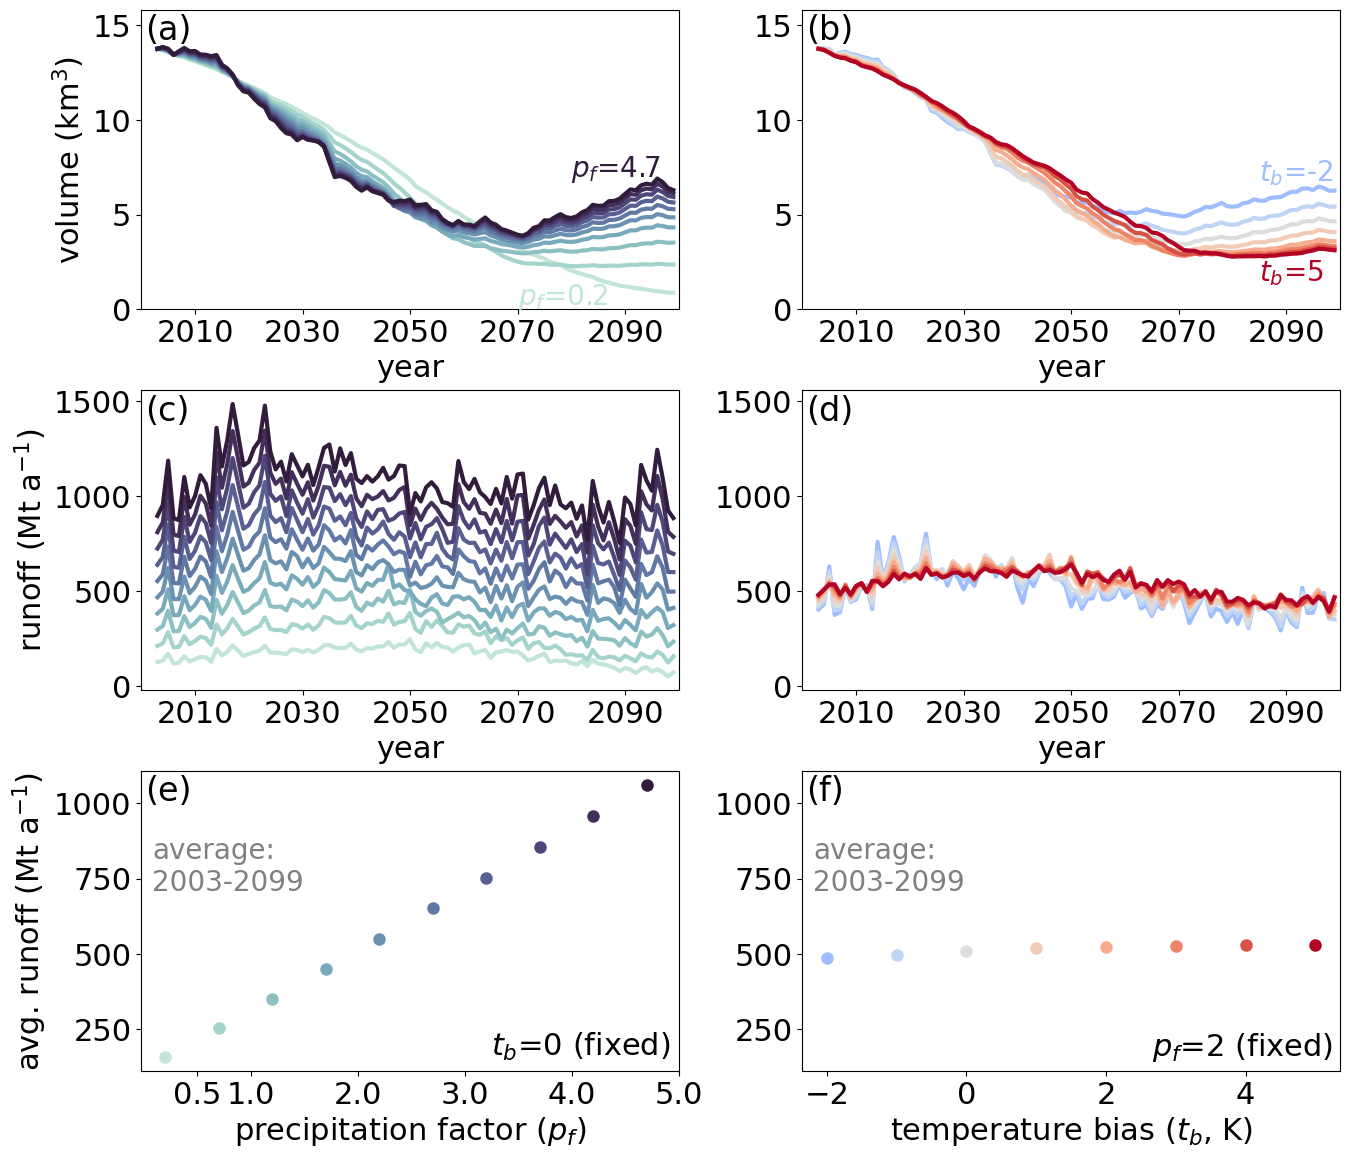

In [9]:
num_dict[13] = '(n)'
num_dict[14] = '(o)'
num_dict[15] = '(p)'
plt.rc('font', size=22)

import matplotlib
from matplotlib import cm

runoff_vars = ['melt_on_glacier','melt_off_glacier','liq_prcp_on_glacier','liq_prcp_off_glacier', 'volume_m3']

#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5.01)

num_text_x = 0.007
num_text_y = 0.9

c= 3
r = 2
ms = 16 #14
ms_x = 11
param = pf
param_to_model = pf_to_model#[:-1]
f = 1
k = 1
pf_to_model_p = pf_to_model#[:-1] #[::4]
pf_to_model_pp = pf_to_model#[:-1] #[::4]

import seaborn as sns
col_pf = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_p))
col_pf_pp = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_pp))

plt.figure(figsize=(14, 12))
pd_data = pd_pf_data.loc[pd_pf_data.temp_b==0].iloc[:-1]
n=5
plt.subplot(c, r, n)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=24, transform=plt.gca().transAxes)

for j,pf in enumerate(pf_to_model_p):
    plt.plot(pf, pd_data.loc[pd_data.pf == pf.round(2), 'avg. runoff'].values,
             '.', color=col_pf[j], ms=ms)
plt.xticks([0.5,1,2,3, 4,5])
plt.ylabel(f'avg. runoff '+r'(Mt a$^{-1}$)')
plt.gca().text(0.02,0.6, 'average:\n2003-2099', fontsize=20, transform=plt.gca().transAxes, color='grey')
plt.xlabel(r'precipitation factor ($p_f$)')
plt.text(0.65,0.05, r'$t_b$'+f'=0 (fixed)', transform=plt.gca().transAxes)

ax_pf_avg_runoff = plt.gca()

nn=1
plt.subplot(c, r, nn)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_pp):
    j_real = pd_data.loc[pd_data.pf==pf.round(2)].index[0]
    plt.plot(np.arange(2003,2100,1),
             pd_data.loc[pd_data.pf == pf.round(2)]['volume_m3'].values[0],
             color = col_pf[j], ms=ms, label = f'prcp. fac={pf:.1f}',lw=3)

plt.xlabel('year')
plt.ylabel('volume '+r'(km$^{3}$)')
plt.xticks(np.arange(2010,2100,20))

plt.ylim([0, pd_pf_data.volume_m3[0][0]*1.15])
#plt.xticks(np.arange(2004,2019,4))
plt.xlim([2000,2100])
ax_pf_volume = plt.gca()

if gdir.rgi_id == 'RGI60-11.01450':
    plt.gca().text(2070,0.25, r'$p_f$=0.2',
               fontsize=20, #transform=plt.gca().transAxes,
               color = col_pf[0])
    plt.gca().text(2080,7, r'$p_f$=4.7',
               fontsize=20, 
               color = col_pf[-1])
else:
    plt.gca().text(2025,45, r'$p_f$=4.7',
               fontsize=20, #transform=plt.gca().transAxes,
               color = col_pf[-1])
    plt.gca().text(2023,7, r'$p_f$=0.2',
               fontsize=20, 
               color = col_pf[0])

nn=3
plt.subplot(c, r, nn)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_pp):
    j_real = pd_data.loc[pd_data.pf==pf.round(2)].index[0]
    plt.plot(np.arange(2003,2100,1),
             pd_data.loc[pd_data.pf == pf.round(2)][runoff_vars].sum(axis=1).values[0],
             color = col_pf[j], ms=ms, label = f'prcp. fac={pf:.1f}',lw=3)
plt.ylabel(f'runoff '+r'(Mt a$^{-1}$)')

plt.xlabel('year')

plt.xticks(np.arange(2010,2100,20))
plt.xlim([2000,2100])
ax_pf_runoff = plt.gca()






############    
### now temp. bias sensitivity plot ... 
pd_data = pd_pf_data.loc[pd_pf_data.pf==2]   #pd_temp_bias_data
temp_bias_to_model_p = temp_bias_to_model#[::4]
n=6
plt.subplot(c, r, n, sharey=ax_pf_avg_runoff)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=24, transform=plt.gca().transAxes)

for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        plt.plot(temp_b, pd_data.loc[pd_data.temp_b == temp_b, 'avg. runoff'].values,
                 '.', color=cm.coolwarm(norm(temp_b)), ms=ms)
    except:
        pass
#plt.ylabel(r'avg. runoff (Mt year$^{-1}$)')
plt.ylabel('')
plt.gca().text(0.02,0.6, 'average:\n2003-2099',
               fontsize=20, transform=plt.gca().transAxes, color = 'grey')
plt.text(0.65,0.05, r'$p_f$'+f'=2 (fixed)', transform=plt.gca().transAxes)

plt.xlabel(r'temperature bias ($t_b$, K)')

nn=2
plt.subplot(c, r, nn, sharey=ax_pf_volume, sharex=ax_pf_volume)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1],
               fontsize=24, transform=plt.gca().transAxes)
for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        j_real = pd_data.loc[pd_data.temp_b==temp_b].index[0]
        plt.plot(np.arange(2003,2100,1),
                 pd_data.loc[pd_data.temp_b == temp_b]['volume_m3'].values[0],
                 color = cm.coolwarm(norm(temp_b)),
                 ms=ms, label = f'temp. b={temp_b:.1f}',lw=3)
    except:
        pass
#plt.ylabel('volume (km$^{3}$)')
plt.ylabel('')
plt.xlabel('year')
plt.xticks(np.arange(2010,2100,20))

if gdir.rgi_id == 'RGI60-11.01450':
    plt.gca().text(2085,6.8, r'$t_b$=-2',
                   fontsize=20, #transform=plt.gca().transAxes,
                   color = cm.coolwarm(norm(-2)))
    plt.gca().text(2085,1.5, r'$t_b$=5',
                   fontsize=20, #transform=plt.gca().transAxes,
                   color = cm.coolwarm(norm(5)))
else:
    plt.gca().text(2025,43, r'$t_b$=-2',
                   fontsize=20, #transform=plt.gca().transAxes,
                   color = cm.coolwarm(norm(-2)))
    plt.gca().text(2025,10, r'$t_b$=5',
                   fontsize=20, #transform=plt.gca().transAxes,
                   color = cm.coolwarm(norm(5)))



nn=4
plt.subplot(c, r, nn, sharey=ax_pf_runoff, sharex=ax_pf_runoff)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)

for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        j_real = pd_data.loc[pd_data.temp_b==temp_b].index[0]
        plt.plot(np.arange(2003,2100,1),
                 pd_data.loc[pd_data.temp_b == temp_b][runoff_vars].sum(axis=1).values[0],
                 color = cm.coolwarm(norm(temp_b)),
                 ms=ms, label = f'temp. b={temp_b:.1f}',lw=3)
    except:
        pass
#plt.ylabel(r'runoff (Mt year$^{-1}$)')
plt.ylabel('')
plt.xlabel('year')

plt.xticks(np.arange(2010,2100,20))


############  
plt.tight_layout(pad=1.01, w_pad=0.4, h_pad= 0.2)
plt.savefig(f'{fig_path}/fig_7_conceptual_parameter_vol_runoff_influence_2003_2099_sfc_type_no_mb_monthly_{gdir.rgi_id}_median_gcm.pdf')
#Schreibtisch/PhD/Schuster_et_al_phd_paper_1/figures/figures_paper_oct_2022/supplements/fig_conceptual_parameter_runoff_influence_figure_sfc_type_no_mb_monthly_hef.pdf

### Additional plot that looks into the annual runoff variance (not inside of manuscript or supplements)

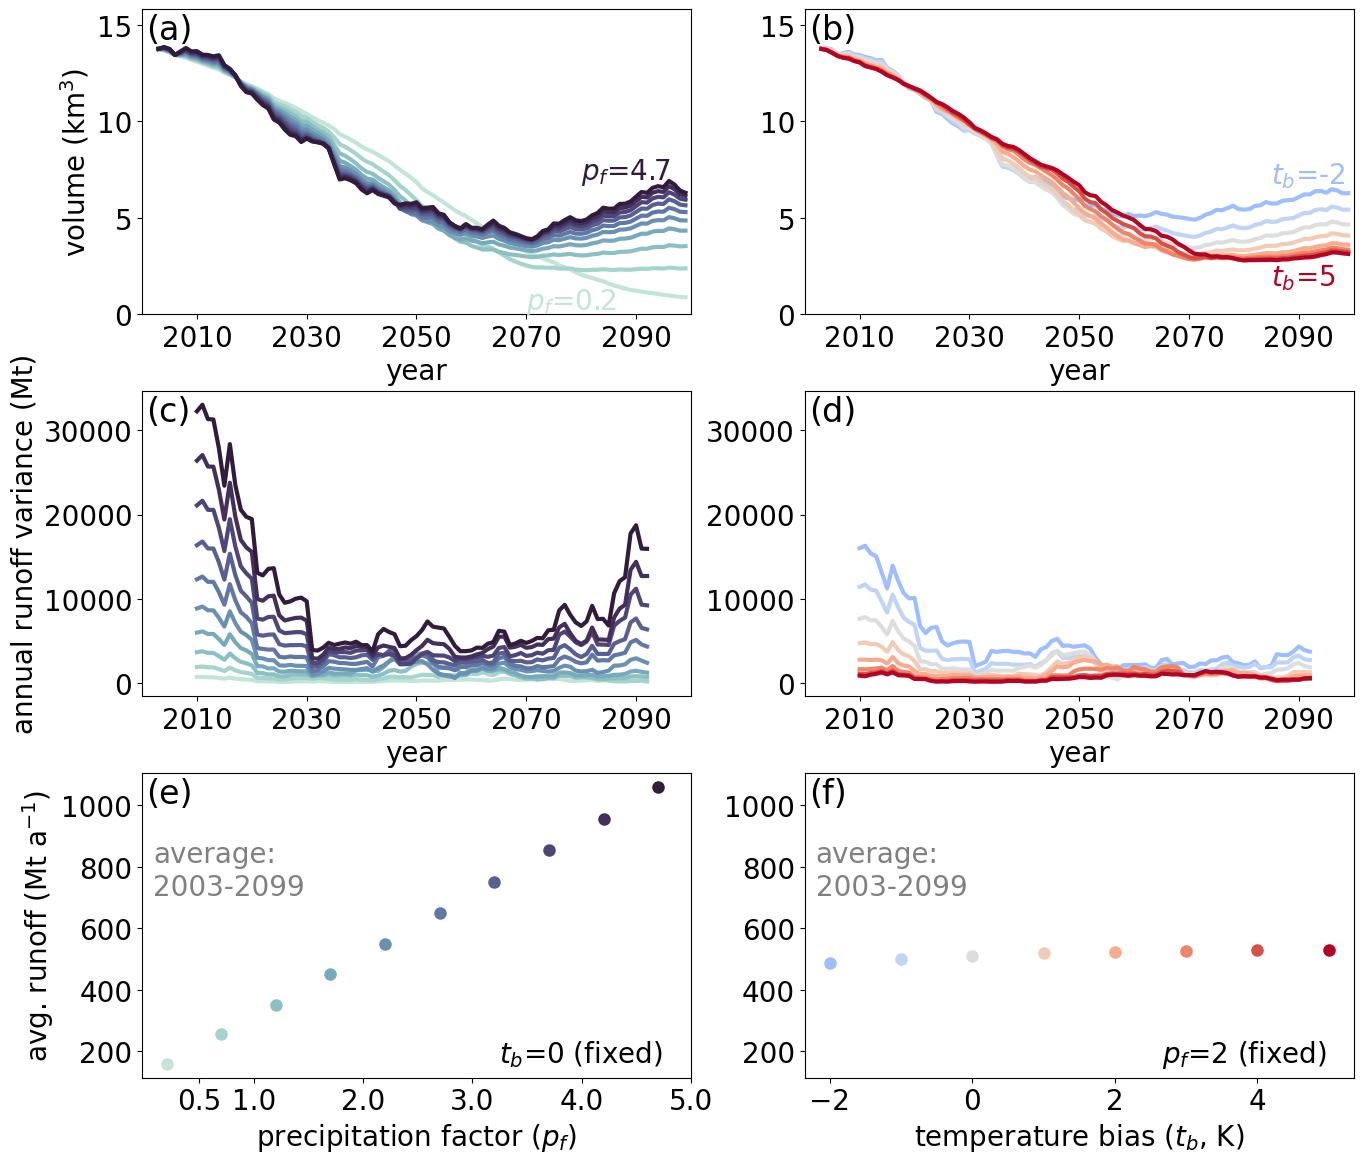

In [69]:

import matplotlib
from matplotlib import cm

runoff_vars = ['melt_on_glacier','melt_off_glacier','liq_prcp_on_glacier','liq_prcp_off_glacier', 'volume_m3']

#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5.01)

num_text_x = 0.007
num_text_y = 0.9

c= 3
r = 2
ms = 16 #14
ms_x = 11
param = pf
param_to_model = pf_to_model#[:-1]
f = 1
k = 1
pf_to_model_p = pf_to_model#[:-1] #[::4]
pf_to_model_pp = pf_to_model#[:-1] #[::4]

import seaborn as sns
col_pf = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_p))
col_pf_pp = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_pp))

plt.figure(figsize=(14, 12))
pd_data = pd_pf_data.loc[pd_pf_data.temp_b==0].iloc[:-1]
n=5
plt.subplot(c, r, n)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=24, transform=plt.gca().transAxes)

for j,pf in enumerate(pf_to_model_p):
    plt.plot(pf, pd_data.loc[pd_data.pf == pf.round(2), 'avg. runoff'].values,
             '.', color=col_pf[j], ms=ms)
plt.xticks([0.5,1,2,3, 4,5])
plt.ylabel(f'avg. runoff '+r'(Mt a$^{-1}$)')
plt.gca().text(0.02,0.6, 'average:\n2003-2099', fontsize=20, transform=plt.gca().transAxes, color='grey')
plt.xlabel(r'precipitation factor ($p_f$)')
plt.text(0.65,0.05, r'$t_b$'+f'=0 (fixed)', transform=plt.gca().transAxes)

ax_pf_avg_runoff = plt.gca()

nn=1
plt.subplot(c, r, nn)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_pp):
    j_real = pd_data.loc[pd_data.pf==pf.round(2)].index[0]
    plt.plot(np.arange(2003,2100,1),
             pd_data.loc[pd_data.pf == pf.round(2)]['volume_m3'].values[0],
             color = col_pf[j], ms=ms, label = f'prcp. fac={pf:.1f}',lw=3)

plt.xlabel('year')
plt.ylabel('volume '+r'(km$^{3}$)')
plt.xticks(np.arange(2010,2100,20))

plt.ylim([0, pd_pf_data.volume_m3[0][0]*1.15])
#plt.xticks(np.arange(2004,2019,4))
plt.xlim([2000,2100])
ax_pf_volume = plt.gca()

if gdir.rgi_id == 'RGI60-11.01450':
    plt.gca().text(2070,0.25, r'$p_f$=0.2',
               fontsize=20, #transform=plt.gca().transAxes,
               color = col_pf[0])
    plt.gca().text(2080,7, r'$p_f$=4.7',
               fontsize=20, 
               color = col_pf[-1])
else:
    plt.gca().text(2025,45, r'$p_f$=4.7',
               fontsize=20, #transform=plt.gca().transAxes,
               color = col_pf[-1])
    plt.gca().text(2023,7, r'$p_f$=0.2',
               fontsize=20, 
               color = col_pf[0])

nn=3
plt.subplot(c, r, nn)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_pp):
    j_real = pd_data.loc[pd_data.pf==pf.round(2)].index[0]
    var = np.lib.stride_tricks.sliding_window_view(pd_data.loc[pd_data.pf==pf.round(2)][runoff_vars].sum(axis=1).values[0], 15).std(axis=1)**2
    plt.plot(np.arange(2003+7,2100-7,1),
            var,
             color = col_pf[j], ms=ms, label = f'prcp. fac={pf:.1f}',lw=3)
plt.ylabel(f'annual runoff variance'+r' (Mt)')

plt.xlabel('year')

plt.xticks(np.arange(2010,2100,20))
plt.xlim([2000,2100])
ax_pf_runoff = plt.gca()


 
### now temp. bias sensitivity plot ... 
pd_data = pd_pf_data.loc[pd_pf_data.pf==2]   #pd_temp_bias_data
temp_bias_to_model_p = temp_bias_to_model#[::4]


n=6
plt.subplot(c, r, n, sharey=ax_pf_avg_runoff)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=24, transform=plt.gca().transAxes)

for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        plt.plot(temp_b, pd_data.loc[pd_data.temp_b == temp_b, 'avg. runoff'].values,
                 '.', color=cm.coolwarm(norm(temp_b)), ms=ms)
    except:
        pass
#plt.ylabel(r'avg. runoff (Mt year$^{-1}$)')
plt.ylabel('')
plt.gca().text(0.02,0.6, 'average:\n2003-2099',
               fontsize=20, transform=plt.gca().transAxes, color = 'grey')
plt.text(0.65,0.05, r'$p_f$'+f'=2 (fixed)', transform=plt.gca().transAxes)

plt.xlabel(r'temperature bias ($t_b$, K)')

nn=2
plt.subplot(c, r, nn, sharey=ax_pf_volume, sharex=ax_pf_volume)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1],
               fontsize=24, transform=plt.gca().transAxes)
for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        j_real = pd_data.loc[pd_data.temp_b==temp_b].index[0]
        plt.plot(np.arange(2003,2100,1),
                 pd_data.loc[pd_data.temp_b == temp_b]['volume_m3'].values[0],
                 color = cm.coolwarm(norm(temp_b)),
                 ms=ms, label = f'temp. b={temp_b:.1f}',lw=3)
    except:
        pass
#plt.ylabel('volume (km$^{3}$)')
plt.ylabel('')
plt.xlabel('year')
plt.xticks(np.arange(2010,2100,20))

if gdir.rgi_id == 'RGI60-11.01450':
    plt.gca().text(2085,6.8, r'$t_b$=-2',
                   fontsize=20, #transform=plt.gca().transAxes,
                   color = cm.coolwarm(norm(-2)))
    plt.gca().text(2085,1.5, r'$t_b$=5',
                   fontsize=20, #transform=plt.gca().transAxes,
                   color = cm.coolwarm(norm(5)))
else:
    plt.gca().text(2025,43, r'$t_b$=-2',
                   fontsize=20, #transform=plt.gca().transAxes,
                   color = cm.coolwarm(norm(-2)))
    plt.gca().text(2025,10, r'$t_b$=5',
                   fontsize=20, #transform=plt.gca().transAxes,
                   color = cm.coolwarm(norm(5)))



nn=4
plt.subplot(c, r, nn, sharey=ax_pf_runoff, sharex=ax_pf_runoff)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)

for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        j_real = pd_data.loc[pd_data.temp_b==temp_b].index[0]
        plt.plot(np.arange(2003+7,2100-7,1),
                 np.lib.stride_tricks.sliding_window_view(pd_data.loc[pd_data.temp_b==temp_b][runoff_vars].sum(axis=1).values[0], 15).std(axis=1)**2,
                 color = cm.coolwarm(norm(temp_b)),
                 ms=ms, label = f'temp. b={temp_b:.1f}',lw=3)
    except:
        pass
#plt.ylabel(r'runoff (Mt year$^{-1}$)')
plt.ylabel('')
plt.xlabel('year')

plt.xticks(np.arange(2010,2100,20))



############  
plt.tight_layout(pad=1.01, w_pad=0.4, h_pad= 0.2)
#plt.savefig(f'{fig_path}/fig_x_vol_runoff_variance_influence_2003_2099_sfc_type_no_mb_monthly_{gdir.rgi_id}_median_gcm.pdf')
#Schreibtisch/PhD/Schuster_et_al_phd_paper_1/figures/figures_paper_oct_2022/supplements/fig_conceptual_parameter_runoff_influence_figure_sfc_type_no_mb_monthly_hef.pdf

#### Fig. S20:

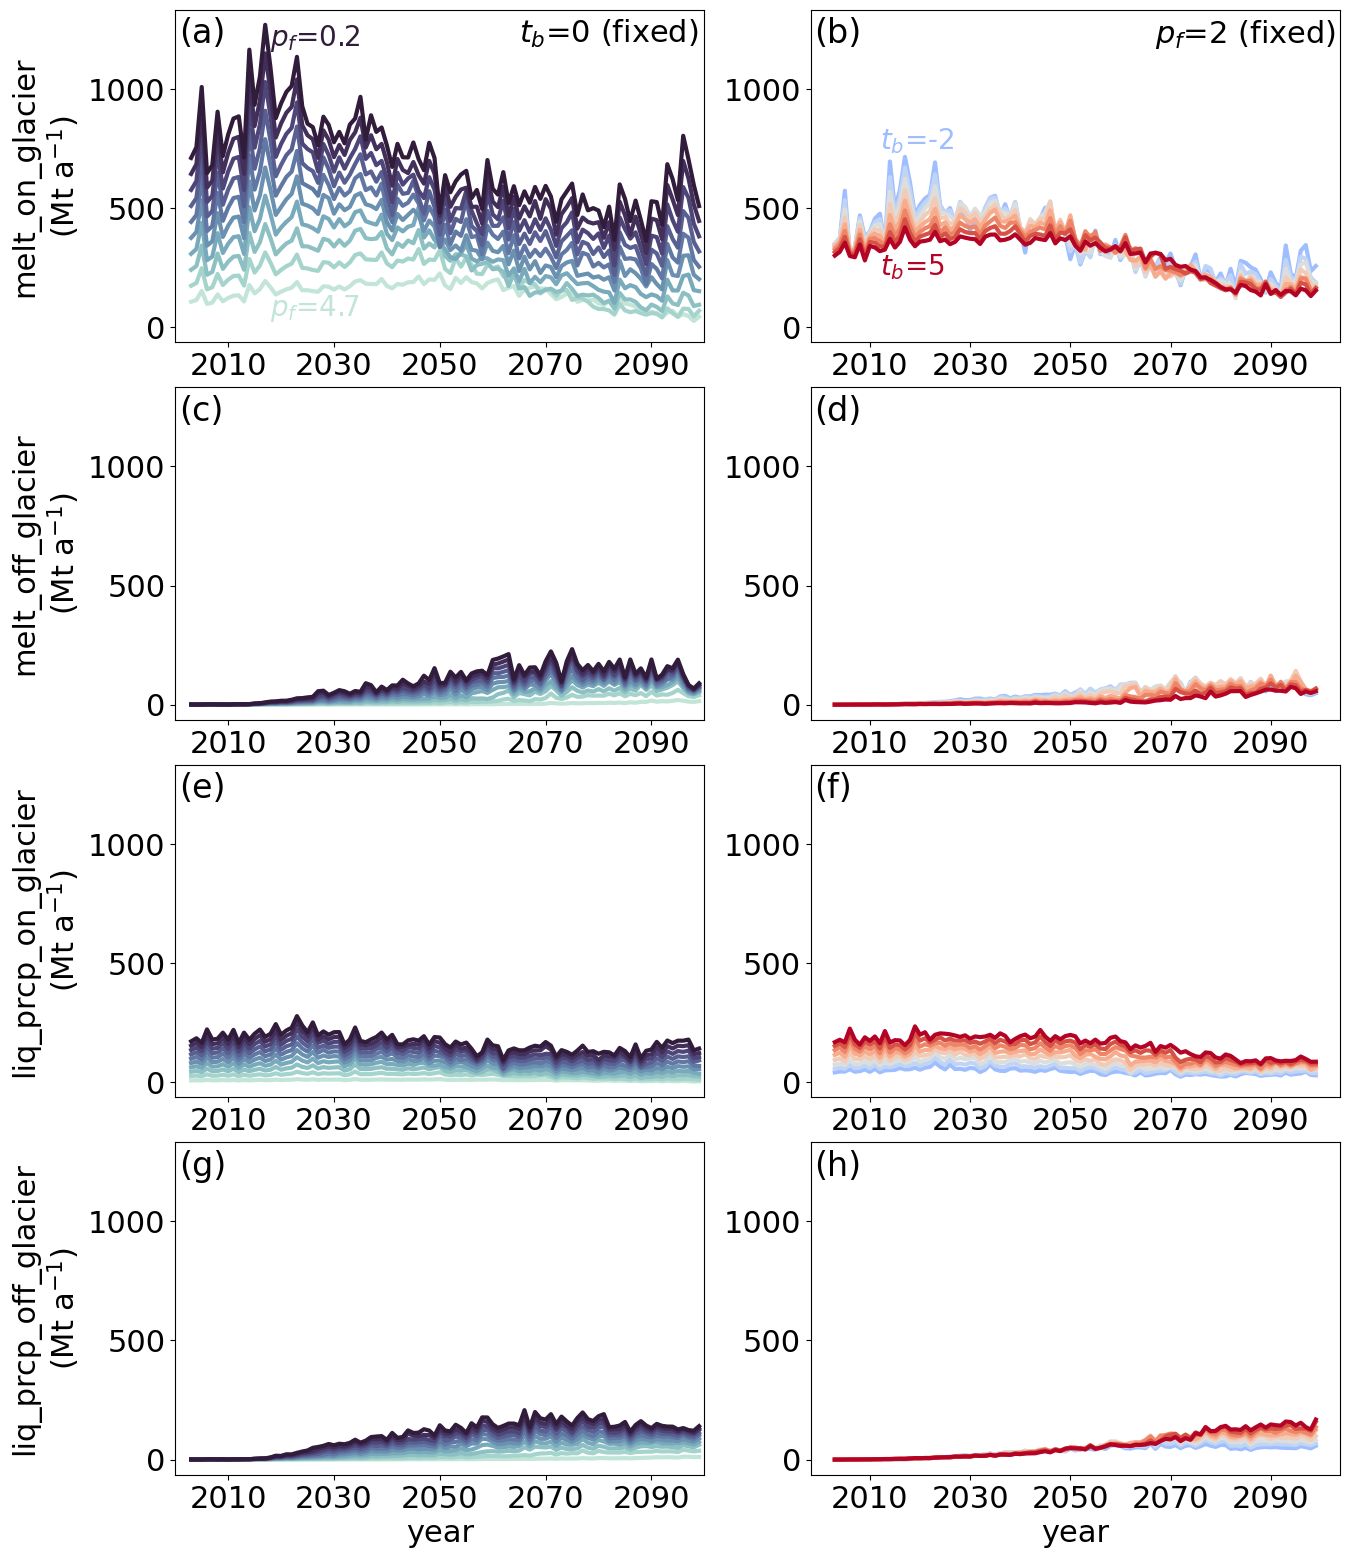

In [11]:
plt.rc('font', size=22)
runoff_vars = ['melt_on_glacier','melt_off_glacier','liq_prcp_on_glacier','liq_prcp_off_glacier', 'volume_m3']

c= 4
r = 2
ms = 16 #14
ms_x = 11
param = pf
param_to_model = pf_to_model#[:-1]
f = 1
k = 1
pf_to_model_p = pf_to_model#[:-1] #[::4]
pf_to_model_pp = pf_to_model#[:-1] #[::4]

import seaborn as sns
col_pf = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_p))
col_pf_pp = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_pp))

plt.figure(figsize=(14, 16))

pd_data = pd_pf_data.loc[pd_pf_data.temp_b==0].iloc[:-1]
nn=1
ax_pf_runoff_v_dict={}
for runoff_v in runoff_vars[:4]:
    if runoff_v != 'melt_on_glacier':
        plt.subplot(c, r, nn, sharey=ax_pf_runoff_v_dict['melt_on_glacier'])
    else:
        plt.subplot(c, r, nn)
        if gdir.rgi_id == 'RGI60-11.01450':
            plt.gca().text(2018,1180, r'$p_f$=0.2',
                       fontsize=20, #transform=plt.gca().transAxes,
                       color = col_pf[-1])
            plt.gca().text(2018,50, r'$p_f$=4.7',
                       fontsize=20, 
                       color = col_pf[0])
        else:
            plt.gca().text(2025,45, r'$p_f$=4.7',
                       fontsize=20, #transform=plt.gca().transAxes,
                       color = col_pf[-1])
            plt.gca().text(2023,7, r'$p_f$=0.2',
                       fontsize=20, 
                       color = col_pf[0])
            
        plt.text(0.65,0.9, r'$t_b$'+f'=0 (fixed)', transform=plt.gca().transAxes)


    plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
    for j,pf in enumerate(pf_to_model_pp):
        j_real = pd_data.loc[pd_data.pf==pf.round(2)].index[0]
        plt.plot(np.arange(2003,2100,1),
                 pd_data.loc[pd_data.pf == pf.round(2)][runoff_v].values[0],
                 color = col_pf[j], ms=ms, label = f'prcp. fac={pf:.1f}',lw=3)
    plt.ylabel(runoff_v+'\n'+ r'(Mt a$^{-1}$)')
    #plt.xticks(np.arange(2004,2019,4))
    plt.xticks(np.arange(2010,2100,20))    
    if runoff_v == runoff_vars[3]:
        plt.xlabel('year')
    else:
        plt.xlabel('')
    plt.xlim([2000,2100])
    ax_pf_runoff_v_dict[runoff_v] = plt.gca()
    nn+=2
     
    
pd_data = pd_pf_data.loc[pd_pf_data.pf==2]   #pd_temp_bias_data
temp_bias_to_model_p = temp_bias_to_model#[::4]
nn=2
for runoff_v in runoff_vars[:4]:
    plt.subplot(c, r, nn, sharey=ax_pf_runoff_v_dict['melt_on_glacier'])
    if runoff_v == 'melt_on_glacier':
        if gdir.rgi_id == 'RGI60-11.01450':
            plt.gca().text(2012,750, r'$t_b$=-2',
                           fontsize=20, #transform=plt.gca().transAxes,
                           color = cm.coolwarm(norm(-2)))
            plt.gca().text(2012,220, r'$t_b$=5',
                           fontsize=20, #transform=plt.gca().transAxes,
                           color = cm.coolwarm(norm(5)))
        else:
            plt.gca().text(2015,43, r'$t_b$=-2',
                           fontsize=20, #transform=plt.gca().transAxes,
                           color = cm.coolwarm(norm(-2)))
            plt.gca().text(2015,10, r'$t_b$=5',
                           fontsize=20, #transform=plt.gca().transAxes,
                           color = cm.coolwarm(norm(5)))
        plt.text(0.65,0.9, r'$p_f$'+f'=2 (fixed)', transform=plt.gca().transAxes)


    #plt.subplot(c, r, nn) #, sharey=ax_pf_runoff_v_dict[runoff_v],sharex=ax_pf_runoff_v_dict[runoff_v])
    plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
    
    for j,temp_b in enumerate(temp_bias_to_model_p):
        try:
            j_real = pd_data.loc[pd_data.temp_b==temp_b].index[0]
            plt.plot(np.arange(2003,2100,1),
                     pd_data.loc[pd_data.temp_b == temp_b][runoff_v].values[0],
                     color = cm.coolwarm(norm(temp_b)),
                     ms=ms, label = r'$t_b$'+f'={temp_b:.1f}',lw=3)
        except:
            pass
    #plt.ylabel(runoff_v+r' (Mt year$^{-1}$)')
    plt.ylabel('')
    if runoff_v == runoff_vars[3]:
        plt.xlabel('year')
    else:
        plt.xlabel('')
    plt.xticks(np.arange(2010,2100,20))
    nn+=2
    
plt.tight_layout(pad=1.01, w_pad=0.4, h_pad= 0.2)
plt.savefig(f'{fig_path}/figures_supplements/fig_S20_conceptual_parameter_runoff_components_influence_2003_2099_sfc_type_no_mb_monthly_{gdir.rgi_id}_median_gcm.pdf')


#### Fig. S21 (for Hintereisferner)

In [10]:
# repeat it for Hintereisferner to do the same plot for Hintereisferner 
df = ['RGI60-11.00897']
gdirs = workflow.init_glacier_directories(df)

gdir = gdirs[0]
melt_f = 200
pf = 1.5

try:
    y0 = gdirs[0].get_climate_info('_daily_W5E5')['baseline_yr_0']
    # One adds 1 because the run ends at the end of the year
    ye = gdirs[0].get_climate_info('_daily_W5E5')['baseline_yr_1'] + 1
except:
    y0 = gdirs[0].get_climate_info('_daily_W5E5')['baseline_hydro_yr_0']
    # One adds 1 because the run ends at the end of the year
    ye = gdirs[0].get_climate_info('_daily_W5E5')['baseline_hydro_yr_1'] + 1

# get the geodetic data for calibration
pd_geodetic = oggm.utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
mb_geodetic = pd_geodetic.loc[df].dmdtda.values * 1000
years = np.arange(2000, 2020, 1)
fls = gdir.read_pickle('inversion_flowlines')
h,w = gdir.get_inversion_flowline_hw()

mb_type = 'mb_monthly' 

sfc_type_distinction = 'no'


grad_type = 'cte'
baseline_climate='W5E5'
if sfc_type_distinction == 'monthly_neg_exp':
    mb_model_sub_class = TIModel_Sfc_Type
    melt_f_update = 'monthly'
    kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp', 'tau_e_fold_yr':1,
                                   'spinup_yrs':6, 'melt_f_update':melt_f_update,
                                    'melt_f_ratio_snow_to_ice':0.5}
elif sfc_type_distinction == 'annual_neg_exp':
    mb_model_sub_class = TIModel_Sfc_Type
    melt_f_update = 'annual'
    kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp', 'tau_e_fold_yr':1,
                                   'spinup_yrs':6, 'melt_f_update':melt_f_update,
                                    'melt_f_ratio_snow_to_ice':0.5}
elif sfc_type_distinction == 'no':
    mb_model_sub_class = TIModel
    kwargs_for_TIModel_Sfc_Type = {}
    
    
mb = mb_model_sub_class(gdir, 200, mb_type=mb_type, grad_type = grad_type,
                         prcp_fac=2.5,
                         baseline_climate=baseline_climate, **kwargs_for_TIModel_Sfc_Type)

gdirs = [gdirs[0]]

runoff_vars = ['melt_off_glacier', 'melt_on_glacier',
               'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'volume_m3']

mbdf = gdir.get_ref_mb_data(input_filesuffix='_monthly_W5E5')
ys_glac = mbdf.index.values

pf_to_model = np.arange(0.2, 5.1, 0.5) # #[0.2,0.25, 0.33,0.5,1,2,3,4,5] #np.arange(0.2, 5.1, 0.5) # 0.1 ... #[0.1, 0.3, 0.7, 1, 1.5, 2, 2.5, 3, 4, 5]
# pf_to_model = [0.2, 1,1.25, 1.5, 2, 4, ]
temp_bias_to_model = np.arange(-5,5.01,1) # changed from 0.1 ..to 0.4, as we only plotted every 4th run anyways ...
pf_to_model_zippi = np.concatenate([pf_to_model, np.repeat(2,len(temp_bias_to_model))])
temp_bias_to_model_zippi = np.concatenate([np.repeat(0, len(pf_to_model)), temp_bias_to_model])
temp_b_l = []
melt_f_l = []
pf_l = []
mb_annual_l = []
volume_l = []
runoff_l = []
gcm_l = []
runoff_vars_d = {'melt_off_glacier':[], 'melt_on_glacier': [],
                 'liq_prcp_off_glacier':[],
                 'liq_prcp_on_glacier':[], 'volume_m3':[]}
load = True ### actually I always need to load it as it makes strings out of the [] arrays ... 
if load:
    for pf,temp_b in zip(pf_to_model_zippi,temp_bias_to_model_zippi):
        try:
            mb.temp_bias = temp_b
            melt_f = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                                          xtol=0.01,
                                                          args=(mb, mb_geodetic, h, w, pf),
                                                          disp=True)

            mb.melt_f = melt_f
            mb.prcp_fac = pf #pf_cte = pf_cte
            # first get it in "ascending" order (necessary for sfc type distinction) !
            mb.get_specific_mb(heights=h, widths=w,
                                                year=np.arange(1979,2020,1))

            # direct annual time series:
            mb_annual = mb.get_specific_mb(heights=h, widths=w,
                                            year=ys_glac)

            oggm.core.climate.apparent_mb_from_any_mb(gdir, mb_model=mb,
                                                  mb_years=np.arange(2000, ye, 1))
            # here glen-a is calibrated to match gdirs glaciers in total 
            # (as there is only one glacier, it just matches perfectly the one glacier!)
            border = 80
            filter = border >= 20
            pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus([gdir],
                                                                  apply_fs_on_mismatch=False,ignore_missing=False,
                                                                  error_on_mismatch=True,
                                                                  filter_inversion_output=filter)

            # so for init_present_time_glacier, automatically the new glen a volume inversion is used!
            workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs) #gdirs_sel)
            output_filesuffix = f'pf_var_hydro_historical_W5E5_pf{pf:.2}_tb{temp_b:.2}_{mb_type}_{grad_type}_no_melt_f_change'
            workflow.execute_entity_task(run_with_hydro,
                                         gdirs, run_task=run_from_climate_data_TIModel,
                                             bias=0,  # will actually point to the residual, should always be zero! 
                                             mb_model_sub_class=mb_model_sub_class,  # we use the temperature-index model variant with surface type distinction!
                                             min_ys=y0,
                                             ye=ye,  # starting and end year of the volume run 
                                             mb_type=mb_type,
                                             grad_type=grad_type,
                                             precipitation_factor=pf,  # take the fitted precipitation factor
                                             temperature_bias = temp_b,
                                             melt_f=melt_f, # set to the calibrated melt_f (that fits to fit_prcp_fac_aneto)
                                             #init_model_filesuffix = '_historical_run',  # start from the stage of the end of the historical run 
                                             #climate_type = 'gcm_data',
                                             kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type,                             
                                             climate_filename='climate_historical',
                                             output_filesuffix=output_filesuffix,
                                             climate_input_filesuffix='W5E5', 
                                             store_model_geometry = True,
                                             all_from_json=False,
                                         no_qc=True)


            #for ensemble in gcms[3:]:
            ds_hydro_gcm_l = []
            for ensemble_s in gcms: #[gcms[0]]: #gcms:
                if ensemble_s == 'ukesm1-0-ll':
                    ensemble = ensemble_s + '_r1i1p1f2'
                else:
                    ensemble = ensemble_s + '_r1i1p1f1'
                for ssp in ['ssp126']: # 'ssp585', 
                    output_filesuffix_gcm = f'pf_var_hydro_{ensemble}_{ssp}_pf{pf:.2}_tb{temp_b:.2}_{mb_type}_{grad_type}_no_melt_f_change'
                    workflow.execute_entity_task(run_with_hydro,
                     gdirs, run_task=run_from_climate_data_TIModel,  # gdirs_sel
                                                 init_model_filesuffix=output_filesuffix,
                                                 ref_geometry_filesuffix=output_filesuffix,  # also use this as area reference!!!!
                                                 ref_area_from_y0=True, # keep the same reference area as historical time period!!!
                                                 bias=0,  # will actually point to the residual, should always be zero! 
                                                 mb_model_sub_class=mb_model_sub_class,  # we use the temperature-index model variant with surface type distinction!
                                                 ys=2019,
                                                 ye=2100,  # starting and end year of the volume run 
                                                 mb_type=mb_type,
                                                 grad_type=grad_type,
                                                 precipitation_factor=pf,  # take the fitted precipitation factor
                                                 temperature_bias = temp_b,
                                                 melt_f=melt_f, # set to the calibrated melt_f (that fits to fit_prcp_fac_aneto)
                                                 #init_model_filesuffix = '_historical_run',  # start from the stage of the end of the historical run 
                                                 #climate_type = 'gcm_data',
                                                 kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type,                             
                                                 climate_filename='gcm_data',
                                                 climate_input_filesuffix=f'ISIMIP3b_{ensemble}_{ssp}_no_correction', 
                                                 output_filesuffix=output_filesuffix_gcm,
                                                 store_model_geometry = True,
                                                 all_from_json=False,
                                                 no_qc=True)        

                    ds_hydro_p = xr.open_dataset(gdirs[0].get_filepath('model_diagnostics')[:-3] + output_filesuffix +'.nc')
                    ds_hydro_f = xr.open_dataset(gdirs[0].get_filepath('model_diagnostics')[:-3] + output_filesuffix_gcm +'.nc')
                    ds_hydro_gcm = xr.concat([ds_hydro_p.sel(time=slice(2003,2019)),
                                          ds_hydro_f], dim='time').sel(time=slice(2003,2099))
                    ds_hydro_gcm['gcm'] = ensemble
                    ds_hydro_gcm_l.append(ds_hydro_gcm)
            ds_hydro = xr.concat(ds_hydro_gcm_l, dim='gcm').median(dim='gcm')
            runoff_s = (ds_hydro[runoff_vars[0]] + ds_hydro[runoff_vars[1]] + ds_hydro[runoff_vars[2]]
                        + ds_hydro[runoff_vars[3]]).values/1e9  #in Mt
            # let's look at the average ... 
            mb_annual_l.append(mb_annual)
            gcm_l.append('median gcm') ### is this actually problematic to do that ??? -> extremes are getting "averaged" out ...
            runoff_l.append(runoff_s.mean())
            melt_f_l.append(melt_f)
            pf_l.append(pf.round(2))
            temp_b_l.append(temp_b)
            for runoff_v in runoff_vars:
                # let's look at the different components -> here we want to have the time series 
                runoff_vars_d[runoff_v].append(ds_hydro[runoff_v].values/1e9)
        except:
            print(temp_b, pf)
            pass

    # todo add the 4 different runoff components (as time series ...)
    pd_pf_data = pd.DataFrame(np.array([temp_b_l, pf_l, melt_f_l, runoff_l,
                                        mb_annual_l, gcm_l]).T,
                 columns = ['temp_b', 'pf', 'melt_f', 'avg. runoff',
                            'MB annual', 'gcm'])
    for runoff_v in runoff_vars:
        pd_pf_data[runoff_v] = runoff_vars_d[runoff_v]
    for j in pd_pf_data.index:
        #assert pd_pf_data[runoff_vars[:4]].sum(axis=1).iloc[j].mean() == pd_pf_data['avg. runoff'].iloc[j]
        np.testing.assert_allclose(pd_pf_data[runoff_vars[:4]].sum(axis=1).iloc[j].mean(), pd_pf_data['avg. runoff'].iloc[j])
    #pd_pf_data.to_csv(f'{data_path}_pf_temp_b_var_influence_runoff_W5E5_{ensemble}_{ssp}_{gdir.rgi_id}.csv')


2023-06-14 14:33:52: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers
2023-06-14 14:33:52: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2023-06-14 14:33:52: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2023-06-14 14:33:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2023-06-14 14:33:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2023-06-14 14:33:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2023-06-14 14:33:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
/home/users/lschuster/.local/lib/python3.10/site-packages/oggm/utils/_workflow.py:3036: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  out = pickle.load(f)
2023-06-14 14:33:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1

-5.0 2.0
-4.0 2.0
-3.0 2.0


2023-06-14 14:34:46: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2023-06-14 14:34:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2023-06-14 14:34:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2023-06-14 14:34:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2023-06-14 14:34:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
/home/users/lschuster/.local/lib/python3.10/site-packages/oggm/utils/_workflow.py:3036: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  out = pickle.load(f)
2023-06-14 14:34:46: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2023-06-14 14:34:46: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2023-06-14 14:34:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2

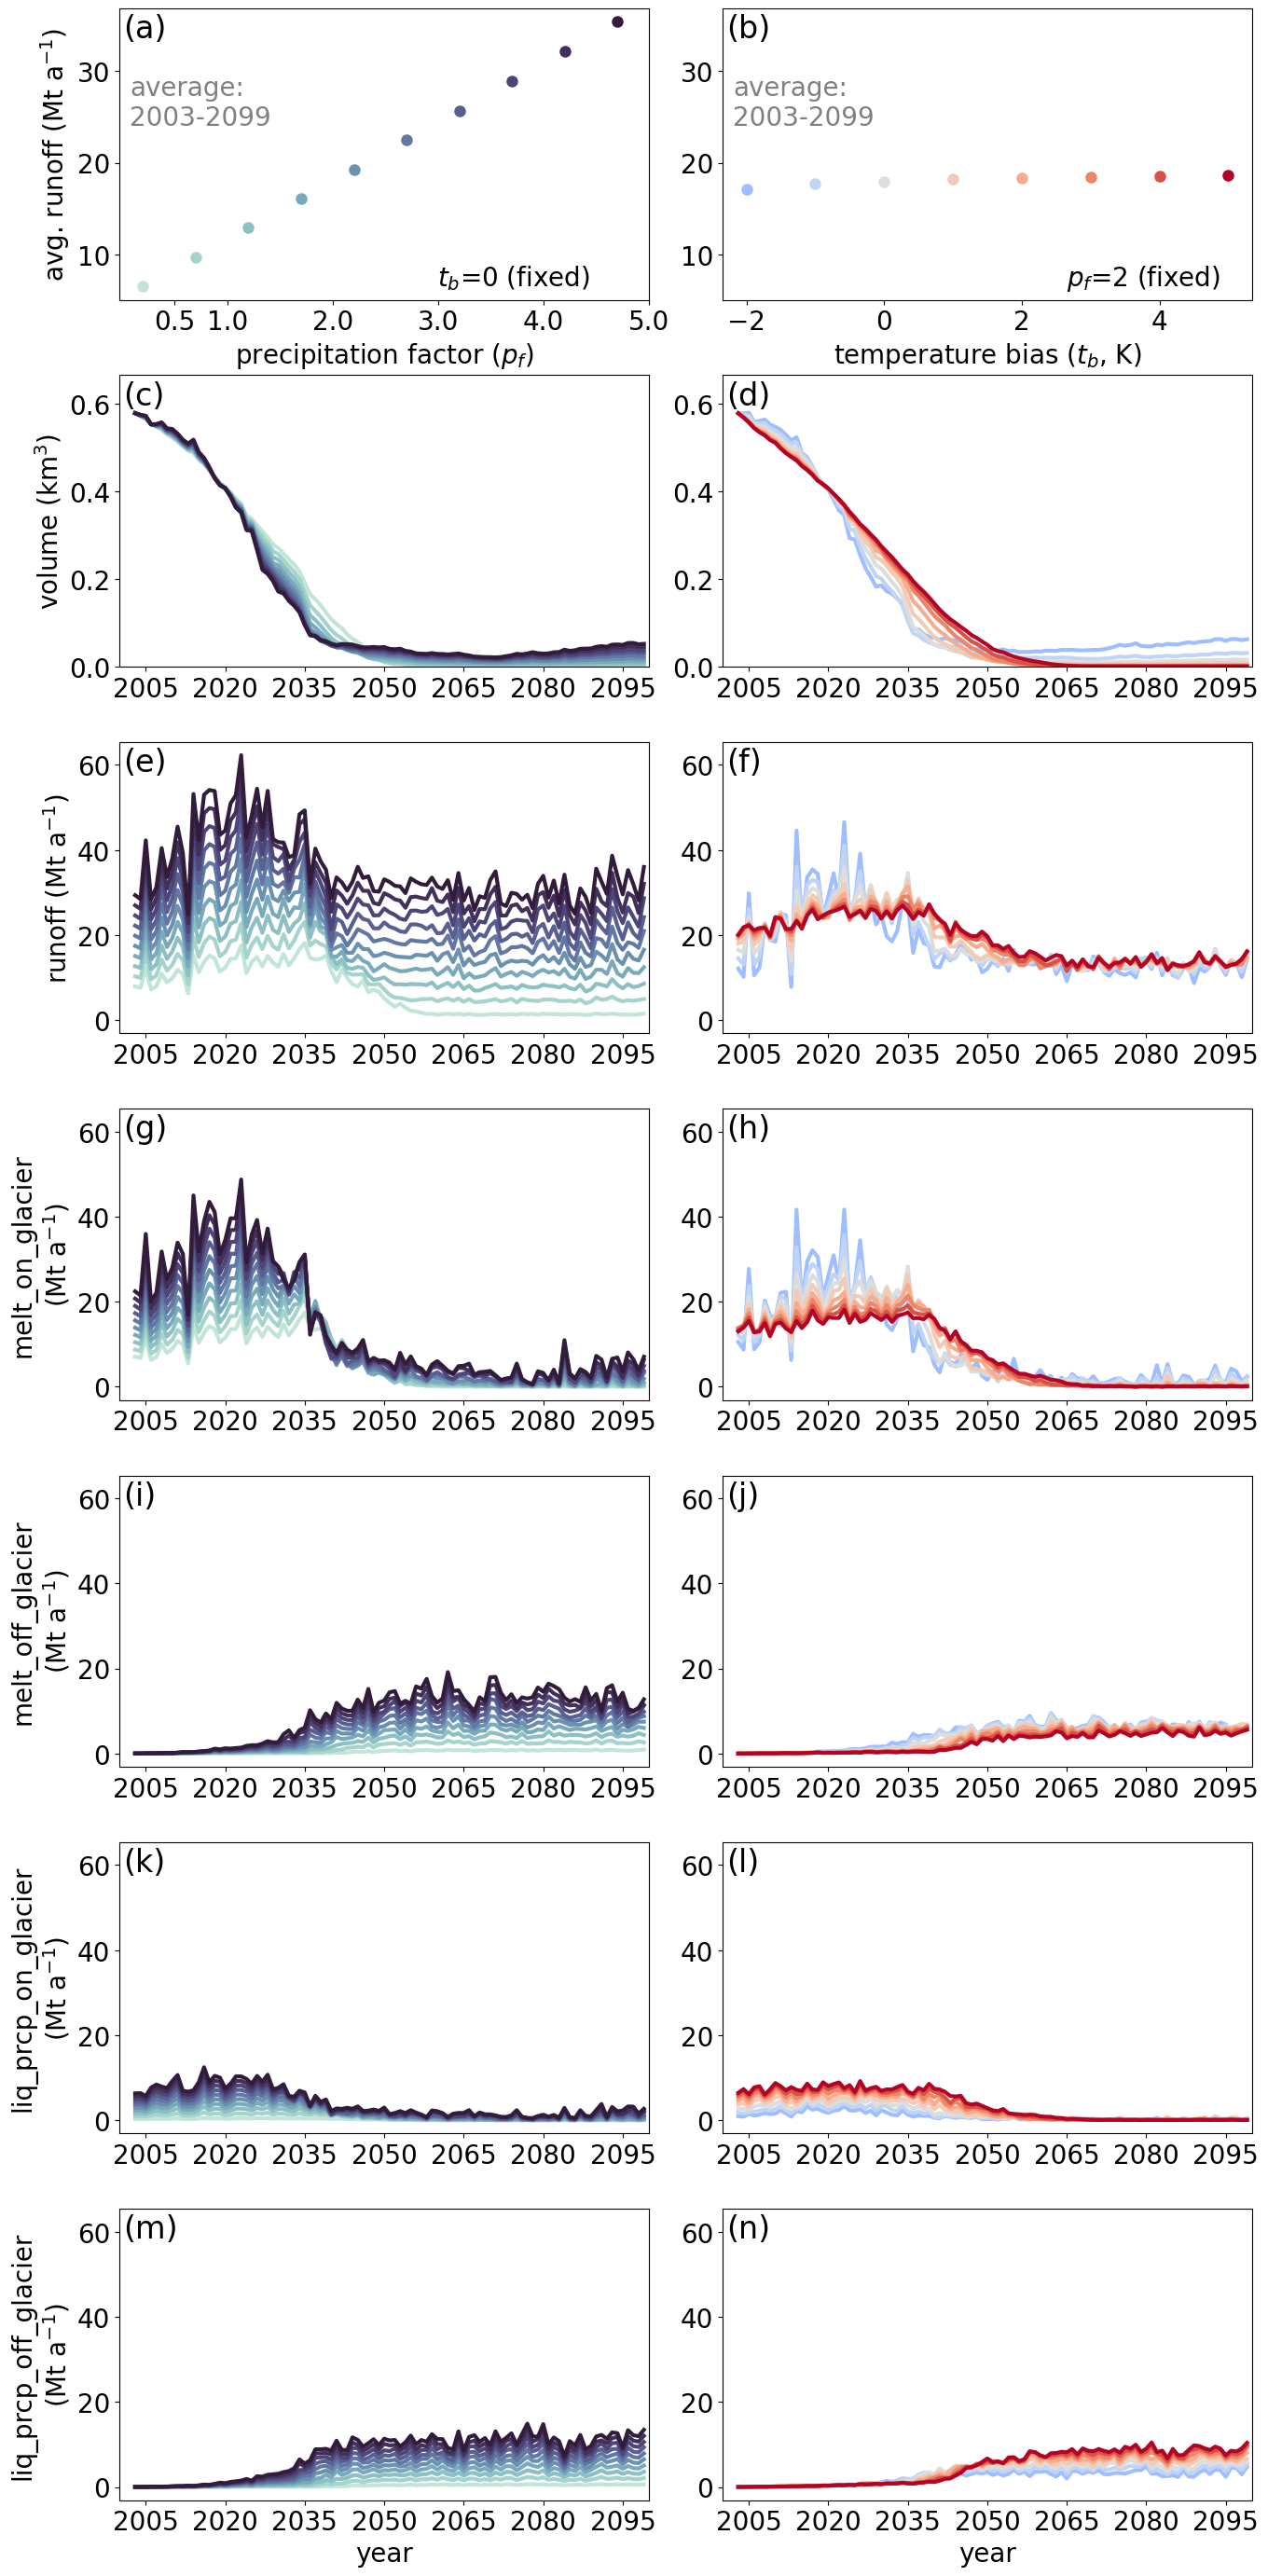

In [11]:
num_dict[13] = '(n)'
num_dict[14] = '(o)'
num_dict[15] = '(p)'

import matplotlib
from matplotlib import cm
plt.rc('font', size=20)

runoff_vars = ['melt_on_glacier','melt_off_glacier',
               'liq_prcp_on_glacier','liq_prcp_off_glacier', 'volume_m3']

#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5.01)

num_text_x = 0.007
num_text_y = 0.9

c= 7
r = 2
ms = 16 #14
ms_x = 11
param = pf
param_to_model = pf_to_model#[:-1]
f = 1
k = 1
pf_to_model_p = pf_to_model#[:-1] #[::4]
pf_to_model_pp = pf_to_model#[:-1] #[::4]

import seaborn as sns
col_pf = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_p))
col_pf_pp = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_pp))

plt.figure(figsize=(14, 28))
pd_data = pd_pf_data.loc[pd_pf_data.temp_b==0].iloc[:-1]
n=1
plt.subplot(c, r, n)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=24, transform=plt.gca().transAxes)

for j,pf in enumerate(pf_to_model_p):
    plt.plot(pf, pd_data.loc[pd_data.pf == pf.round(2), 'avg. runoff'].values,
             '.', color=col_pf[j], ms=ms)
plt.xticks([0.5,1,2,3, 4,5])
plt.ylabel(f'avg. runoff '+r'(Mt a$^{-1}$)')
plt.gca().text(0.02,0.6, 'average:\n2003-2099', fontsize=20, transform=plt.gca().transAxes, color='grey')
plt.xlabel(r'precipitation factor ($p_f$)')
plt.text(0.6,0.05, r'$t_b$'+f'=0 (fixed)', transform=plt.gca().transAxes)

ax_pf_avg_runoff = plt.gca()

nn=3
plt.subplot(c, r, nn)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_pp):
    j_real = pd_data.loc[pd_data.pf==pf.round(2)].index[0]
    plt.plot(np.arange(2003,2100,1),
             pd_data.loc[pd_data.pf == pf.round(2)]['volume_m3'].values[0],
             color = col_pf[j], ms=ms, label = f'prcp. fac={pf:.1f}',lw=3)

plt.xlabel('')
plt.ylabel('volume '+r'(km$^{3}$)')
plt.xticks(np.arange(2005,2100,10))
plt.ylim([0, pd_pf_data.volume_m3[0][0]*1.15])
#plt.xticks(np.arange(2004,2019,4))
plt.xlim([2000,2100])
ax_pf_volume = plt.gca()

nn=5
plt.subplot(c, r, nn)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_pp):
    j_real = pd_data.loc[pd_data.pf==pf.round(2)].index[0]
    plt.plot(np.arange(2003,2100,1),
             pd_data.loc[pd_data.pf == pf.round(2)][runoff_vars].sum(axis=1).values[0],
             color = col_pf[j], ms=ms, label = f'prcp. fac={pf:.1f}',lw=3)
plt.ylabel(f'runoff '+r'(Mt a$^{-1}$)')

plt.xlabel('')
plt.xticks(np.arange(2005,2100,10))
plt.xlim([2000,2100])
ax_pf_runoff = plt.gca()


nn=7
ax_pf_runoff_v_dict={}
for runoff_v in runoff_vars[:4]:
    plt.subplot(c, r, nn, sharey=ax_pf_runoff)
    plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
    for j,pf in enumerate(pf_to_model_pp):
        j_real = pd_data.loc[pd_data.pf==pf.round(2)].index[0]
        plt.plot(np.arange(2003,2100,1),
                 pd_data.loc[pd_data.pf == pf.round(2)][runoff_v].values[0],
                 color = col_pf[j], ms=ms, label = f'prcp. fac={pf:.1f}',lw=3)
    plt.ylabel(runoff_v+'\n'+ r'(Mt a$^{-1}$)')
    #plt.xticks(np.arange(2004,2019,4))
    plt.xticks(np.arange(2005,2100,10))    
    if runoff_v == runoff_vars[3]:
        plt.xlabel('year')
    else:
        plt.xlabel('')
    plt.xlim([2000,2100])
    ax_pf_runoff_v_dict[runoff_v] = plt.gca()
    nn+=2

############    
### now temp. bias sensitivity plot ... 
pd_data = pd_pf_data.loc[pd_pf_data.pf==2]   #pd_temp_bias_data
temp_bias_to_model_p = temp_bias_to_model#[::4]
n=2
plt.subplot(c, r, n, sharey=ax_pf_avg_runoff)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=24, transform=plt.gca().transAxes)

for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        plt.plot(temp_b, pd_data.loc[pd_data.temp_b == temp_b, 'avg. runoff'].values,
                 '.', color=cm.coolwarm(norm(temp_b)), ms=ms)
    except:
        pass
#plt.ylabel(r'avg. runoff (Mt year$^{-1}$)')
plt.ylabel('')
plt.gca().text(0.02,0.6, 'average:\n2003-2099',
               fontsize=20, transform=plt.gca().transAxes, color = 'grey')
plt.text(0.65,0.05, r'$p_f$'+f'=2 (fixed)', transform=plt.gca().transAxes)

plt.xlabel(r'temperature bias ($t_b$, K)')

nn=4
plt.subplot(c, r, nn, sharey=ax_pf_volume, sharex=ax_pf_volume)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1],
               fontsize=24, transform=plt.gca().transAxes)
for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        j_real = pd_data.loc[pd_data.temp_b==temp_b].index[0]
        plt.plot(np.arange(2003,2100,1),
                 pd_data.loc[pd_data.temp_b == temp_b]['volume_m3'].values[0],
                 color = cm.coolwarm(norm(temp_b)),
                 ms=ms, label = f'temp. b={temp_b:.1f}',lw=3)
    except:
        pass
#plt.ylabel('volume (km$^{3}$)')
plt.ylabel('')
plt.xlabel('')
plt.xticks(np.arange(2005,2100,15))

nn=6
plt.subplot(c, r, nn, sharey=ax_pf_runoff, sharex=ax_pf_runoff)
plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)

for j,temp_b in enumerate(temp_bias_to_model_p):
    try:
        j_real = pd_data.loc[pd_data.temp_b==temp_b].index[0]
        plt.plot(np.arange(2003,2100,1),
                 pd_data.loc[pd_data.temp_b == temp_b][runoff_vars].sum(axis=1).values[0],
                 color = cm.coolwarm(norm(temp_b)),
                 ms=ms, label = f'temp. b={temp_b:.1f}',lw=3)
    except:
        pass
plt.ylabel('')
plt.xlabel('')
plt.xticks(np.arange(2005,2100,15))

nn=8
for runoff_v in runoff_vars[:4]:
    plt.subplot(c, r, nn, sharey=ax_pf_runoff_v_dict[runoff_v],sharex=ax_pf_runoff_v_dict[runoff_v])
    plt.gca().text(num_text_x,num_text_y, num_dict[nn-1], fontsize=24, transform=plt.gca().transAxes)
    
    for j,temp_b in enumerate(temp_bias_to_model_p):
        try:
            j_real = pd_data.loc[pd_data.temp_b==temp_b].index[0]
            plt.plot(np.arange(2003,2100,1),
                     pd_data.loc[pd_data.temp_b == temp_b][runoff_v].values[0],
                     color = cm.coolwarm(norm(temp_b)),
                     ms=ms, label = r'$t_b$'+f'={temp_b:.1f}',lw=3)
        except:
            pass
    #plt.ylabel(runoff_v+r' (Mt year$^{-1}$)')
    plt.ylabel('')
    if runoff_v == runoff_vars[3]:
        plt.xlabel('year')
    else:
        plt.xlabel('')
    plt.xticks(np.arange(2005,2100,15))
    nn+=2

############  
plt.tight_layout(pad=1.01, w_pad=0.4, h_pad= 0.2)
plt.savefig(f'{fig_path}/figures_supplements/fig_S21_conceptual_parameter_runoff_influence_2003_2099_sfc_type_no_mb_monthly_{gdir.rgi_id}_median_gcm.pdf')
